# Exercise 2

- Use the biker.png template from Exercise materials to do Kalman filter tracking in the traffic video in Exercise materials.
  Hints: See this Python implementation for pointers. You can define the state as the position and velocity of the biker, and use the output of mean shift or cam shift (or a detection method of your choice) for the measurement update (note: we only measure position!). You will need to define a measurement matrix, a state transition matrix (motion model), as well as covariance matrices for the measurement and process (model) noise. You can start with unit matrices, and experiment with the parameters.
- What happens if you skip the measurement step for certain frames?
  Extra: Visualize the position uncertainty (errorCovPost attribute in OpenCV) as an ellipse. Plot the measured vs. Kalman filtered position over time and compare.


In [1]:
# Importing libraries & packages
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import time
import glob
import sys

# Define data path + output folder
data = "../Data/"
output = "output/"

In [2]:
# Initialize kalman filter with 4 state variables and 2 measurement variables
kalman = cv.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array(
    [[1, 0, 0, 0], [0, 1, 0, 0]], np.float32
)  # Setup a 2x4 measurement matrix, maps x and y coordinates to our 4-dimensional state vector

kalman.transitionMatrix = np.array(
    [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32
)  # Setup a 4x4 transition matrix, defines how state vectors evolve from time step 't' to 't+1'
# based on a simple linear motion model, where objects move linearly at constant velocity.
# First two rows map position estimates onto future position estimates.
# Last two rows maintain unchanged predictions about velocities.

kalman.processNoiseCov = (
    np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    * 0.03
)  # Setup a 4x4 noise process covariance matrix, represent the uncertainty in the motion model.
# Affects how the kalman filter predicts the next state.
# We setup diagonal matrix scaled by 0.03, meaning we add small errors to each of our 4 variables.

kalman_prediction = np.zeros((2, 1), np.float32)

In [3]:
def predict(coord_x, coord_y):
    measured = np.array(
        [[np.float32(coord_x)], [np.float32(coord_y)]]
    )  # Create a measurement vector based on object position (x,y)
    kalman.correct(
        measured
    )  # We update the kalman filter's state estimate with the measurement data
    predicted = kalman.predict()  # We predict coordinates (px,py)
    px, py = int(predicted[0]), int(
        predicted[1]
    )  # We extract the prediction coordinates
    return px, py

In [4]:
def center(points):
    x = np.float32((points[0][0] + points[1][0] + points[2][0] + points[3][0]) / 4.0)
    y = np.float32((points[0][1] + points[1][1] + points[2][1] + points[3][1]) / 4.0)
    return np.array([np.float32(x), np.float32(y)], np.float32)

## My solution with meanshift:


In [5]:
# Initialize video capture object
cap = cv.VideoCapture(data + "slow_traffic_small.mp4")

# Get height and width from data
img = cv.imread(data + "biker.png")
h, w, _ = img.shape

# Setup initial location of window
x, y, w, h = 591, 180, w, h
track_window = (x, y, 20, 25)

# set up the ROI for tracking
frame = cv.imread(output + "frame114.png")
roi = frame[y : y + h, x : x + w]
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
# mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.))) # Original mask
mask = cv.inRange(
    hsv_roi, np.array((10.0, 36.0, 68.0)), np.array((180.0, 255.0, 255.0))
)  # Tried to change some params
roi_hist = cv.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)

count = 0
while 1:
    ret, frame = cap.read()

    if ret == True:
        if count >= 114:
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            dst = cv.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

            # Apply meanshift to get the new location
            ret, track_window = cv.meanShift(dst, track_window, term_crit)

            # Draw observation on image - in green
            x, y, w, h = track_window
            img2 = cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # print(f"x: {x}, y: {y}")

            # Predict coordinates
            prediction = predict(x, y)

            # draw predicton on image - in red
            img2 = cv.rectangle(
                frame,
                (prediction[0], prediction[1]),
                (prediction[0] + w, prediction[1] + h),
                (0, 0, 255),
                1,
            )
            # print(f"prediction: {prediction}")

            cv.imshow("Motion Tracking, MeanShift + Kalman", img2)
            k = cv.waitKey(30) & 0xFF
            if k == 27:
                break
        else:
            count += 1
            continue
            cv.imshow("img2", frame)
            k = cv.waitKey(30) & 0xFF
            if k == 27:
                break
    else:
        break

cv.destroyAllWindows()
print("Successfully exited!")

C:\Users\simon\AppData\Local\Temp\ipykernel_8908\464776068.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  px, py = int(predicted[0]), int(


Successfully exited!


## My solution with camshift:


C:\Users\simon\AppData\Local\Temp\ipykernel_8908\464776068.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  px, py = int(predicted[0]), int(


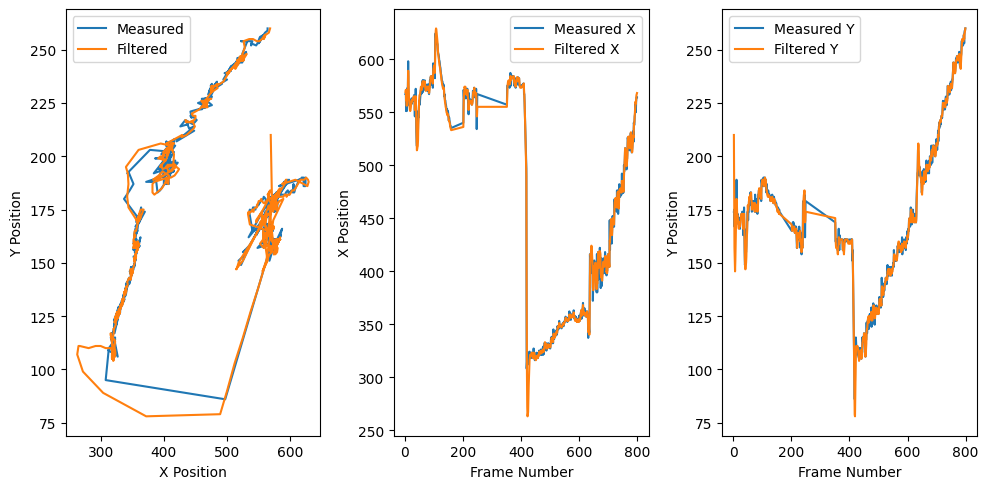

Successfully exited!


In [11]:
# Initialize video capture object
cap = cv.VideoCapture(data+"slow_traffic_small.mp4")

# Get height and width from data
img = cv.imread(data+"biker.png")
h,w,_ = img.shape

# Setup initial location of window
x, y, w, h = 591, 180, w, h
track_window = (x, y, w, h)

# set up the ROI for tracking
frame = cv.imread(output+"frame114.png")
roi = frame[y:y+h, x:x+w]
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
#mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.))) # Original mask
mask = cv.inRange(hsv_roi, np.array((10., 36., 68.)), np.array((180.,255.,255.))) # Tried to change some params
roi_hist = cv.calcHist([hsv_roi],[0, 1],mask,[180, 256],[0,180, 0, 256])
cv.normalize(roi_hist,roi_hist,0,255,cv.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

# Test - Define the text and its properties
org = (10, 30)  # Adjusted position for upper-left corner
font = cv.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (0, 255, 0)  # Green color in BGR
thickness = 2
lineType = cv.LINE_AA

# If < 40 frames are skipped, kalman filter acting up
th1 = 160
th2 = th1 + 40

# Initialize lists to store measured and filtered positions
measured_positions = []
filtered_positions = []

# Initialize lists to store error covariance information
error_covariances = []

# Initialize a list to store frame numbers (time axis)
frame_numbers = []


count = 0
while(1):
    ret, frame = cap.read()
    
    text = f"Frame: {count}"
    cv.putText(frame, text, org, font, fontScale, color, thickness, lineType)
    
    # Skip frames
    if count <= 1:
        count += 1
        continue
    elif th1 <= count <= th2:
        count += 1
        continue
    elif 250 <= count <= 350:
        count += 1
        continue
    elif count == 800:
        count += 1
        break
    
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsv],[0, 1],roi_hist,[0,180,0,256],1)
    
    # Apply meanshift to get the new location
    ret, track_window = cv.CamShift(dst,track_window, term_crit)
    
    # Draw observation on image - in green
    x,y,w,h = track_window
    img2 = cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #print(f"x: {x}, y: {y}")
    
    # Predict coordinates - x,y coordinates for upper left corner
    prediction = predict(x,y)
    #print(f"prediction (x,y): {prediction}")

    # Extract the error covariance

    # Store the measured and filtered positions
    measured_positions.append((x, y))
    filtered_positions.append((prediction[0], prediction[1]))
    frame_numbers.append(count)
    
    error_covariance = kalman.errorCovPost
    error_covariances.append(error_covariance)
    
    # Calculates center 
    xCenter = (prediction[0]*2 + w ) / 2
    yCenter = (prediction[1]*2 + h) / 2
    
    # Calculates bottom right corner
    #x2 = (prediction[0] + w) 
    #y2 = (prediction[1] + h)
    
    # draw predicton on image - in red
    img2 = cv.rectangle(frame,(prediction[0],prediction[1]), (prediction[0] + w, prediction[1] + h), (0,0,255), 1)
    # Draw prediction on image - in cyan
    img2 = cv.circle(frame, (int(xCenter), int(yCenter)), 5, (255, 255, 0), 2)
    
    cv.imshow('Motion Tracking, CamShift + Kalman',img2)
    k = cv.waitKey(1) & 0xff
    count += 1
    if k == 27:
        break

# Plot the measured and filtered positions
measured_x = [pos[0] for pos in measured_positions]
measured_y = [pos[1] for pos in measured_positions]
filtered_x = [pos[0] for pos in filtered_positions]
filtered_y = [pos[1] for pos in filtered_positions]

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.plot(measured_x, measured_y, label='Measured')
plt.plot(filtered_x, filtered_y, label='Filtered')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()

plt.subplot(132)
plt.plot(frame_numbers, measured_x, label='Measured X')
plt.plot(frame_numbers, filtered_x, label='Filtered X')
plt.xlabel('Frame Number')
plt.ylabel('X Position')
plt.legend()

plt.subplot(133)
plt.plot(frame_numbers, measured_y, label='Measured Y')
plt.plot(frame_numbers, filtered_y, label='Filtered Y')
plt.xlabel('Frame Number')
plt.ylabel('Y Position')
plt.legend()

#plt.subplot(133)
#for error_covariance in error_covariances:
#    ellipse = Ellipse((filtered_x[-1], filtered_y[-1]), width=error_covariance[0, 0], height=error_covariance[1, 1], fill=False, color='red')
#    plt.gca().add_patch(ellipse)
#plt.xlabel('X Position')
#plt.ylabel('Y Position')
plt.tight_layout()
plt.show()            
        
    
cv.destroyAllWindows()   
print("Successfully exited!")

## Mark Solution:


In [7]:
def center(points):
    x = np.float32((points[0][0] + points[1][0] + points[2][0] + points[3][0]) / 4.0)
    y = np.float32((points[0][1] + points[1][1] + points[2][1] + points[3][1]) / 4.0)
    return np.array([np.float32(x), np.float32(y)], np.float32)

In [8]:
# Initialize video capture object
cap = cv.VideoCapture(data + "slow_traffic_small.mp4")

# Get height and width from data
img = cv.imread(data + "biker.png")
h, w, _ = img.shape

# Setup initial location of window
x, y, w, h = 591, 180, w, h
track_window = (x, y, w, h)

# set up the ROI for tracking
frame = cv.imread(output + "frame114.png")
roi = frame[y : y + h, x : x + w]
hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
# mask = cv.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.))) # Original mask
mask = cv.inRange(
    hsv_roi, np.array((10.0, 36.0, 68.0)), np.array((180.0, 255.0, 255.0))
)  # Tried to change some params
template_hist = cv.calcHist([hsv_roi], [0, 1], mask, [180, 256], [0, 180, 0, 256])
cv.normalize(template_hist, template_hist, 0, 255, cv.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)

count = 0
while 1:
    ret, frame = cap.read()

    if ret == True:
        if count >= 114:
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            dst = cv.calcBackProject([hsv], [0, 1], template_hist, [0, 180, 0, 256], 1)

            # Apply meanshift to get the new location
            ret, track_window = cv.CamShift(dst, track_window, term_crit)
            cv.normalize(dst, dst, 0, 255, cv.NORM_MINMAX)

            # Draw observation on image - in green
            x, y, w, h = track_window
            img2 = cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # print(f"x: {x}, y: {y}")

            # Predict coordinates
            pts = cv.boxPoints(ret)
            pts = np.int0(pts)
            test = kalman.correct(center(pts))
            kalman_prediction = kalman.predict()

            x, y, w, h = track_window
            # frame = cv.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 1)
            frame = cv.circle(
                frame,
                (int(kalman_prediction[0]), int(kalman_prediction[1])),
                3,
                (0, 0, 255),
                -1,
            )

            cv.imshow("(Solution) Motion Tracking, CamShift + Kalman", img2)
            k = cv.waitKey(30) & 0xFF
            if k == 27:
                break
        else:
            count += 1
            continue
            cv.imshow("img2", frame)
            k = cv.waitKey(30) & 0xFF
            if k == 27:
                break
    else:
        break

cv.destroyAllWindows()
print("Successfully exited!")

C:\Users\simon\AppData\Local\Temp\ipykernel_8908\4262016743.py:46: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  pts = np.int0(pts)
C:\Users\simon\AppData\Local\Temp\ipykernel_8908\4262016743.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  (int(kalman_prediction[0]), int(kalman_prediction[1])),


Successfully exited!
